# Explolation09
## 네이버 영화리뷰 감정분석 도전하기

In [11]:
!pip install --upgrade gensim==3.8.0

### 필요한 모듈 가져오기.

In [12]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
from konlpy.tag import Mecab
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant


print(gensim.__version__)

3.8.0


### 1) 데이터 준비와 확인

In [13]:


# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성
#### 데이터중복제거
#### 결측치제거
#### 한국어 토크나이저 사용
#### 불용어제거
#### 사전 구성
#### 텍스트인덱스 스트링으로 변환
#### 데이터나누기
#### 필자는 단어장의수는 10000개로 구성해주었다.

In [14]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):# 단어장 10000개로구성
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [15]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [16]:
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95

In [17]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

In [18]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens) # 표준편차의 2배이상 차이나면 이상치라고 생각해 제거해준다.
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

# 패딩 추가
# 가장 마지막 위치의 단어가 state에 가장 많은 영향을 미치므로 padding은 pre로 지정.
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 필자는 max_len설정기준을 평균에서 표준편자 2배이상차이나는것은 삭제해주도록 max_len을 설정해주었고, 
### 전체문장의 7프로정도 삭제되므로 괜찮은것같다. 처리하도록하자.

### 4) 모델 구성 및 validation set 구성
### validation set 구성

In [19]:
# 학습 데이터 중 20000개를 validation set으로 사용
X_val = X_train[:20000]   
y_val = y_train[:20000]

partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


### 모델 3가지 구성

In [76]:
vocab_size = 10000
word_vector_dim = 200

lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))
lstm.summary()

cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 6, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(4))
cnn.add(keras.layers.Conv1D(16, 6, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(8, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))
cnn.summary()

gmax = keras.Sequential()
gmax.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmax.add(keras.layers.Dense(8, activation='relu'))
gmax.add(keras.layers.GlobalAveragePooling1D())
gmax.add(keras.layers.Dense(1, activation='sigmoid'))
gmax.summary()

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_87 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
lstm_29 (LSTM)               (None, 8)                 6688      
_________________________________________________________________
dense_178 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_179 (Dense)            (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_88 (Embedding)     (None, None, 200)         2000000   
____________________

### 5) 모델훈련개시

In [77]:
lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

lstm_model = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=2,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

cnn_model = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=2,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

gmax.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

gmax_model = gmax.fit(partial_X_train,
                    partial_y_train,
                    epochs=3,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/2
247/247 [==============================] - 3s 8ms/step - loss: 0.5398 - accuracy: 0.7851 - val_loss: 0.4818 - val_accuracy: 0.8411
Epoch 2/2
247/247 [==============================] - 2s 6ms/step - loss: 0.4503 - accuracy: 0.8539 - val_loss: 0.4505 - val_accuracy: 0.8442
Epoch 1/2
247/247 [==============================] - 2s 6ms/step - loss: 0.4297 - accuracy: 0.7985 - val_loss: 0.3385 - val_accuracy: 0.8519
Epoch 2/2
247/247 [==============================] - 2s 6ms/step - loss: 0.2955 - accuracy: 0.8756 - val_loss: 0.3266 - val_accuracy: 0.8583
Epoch 1/3
493/493 [==============================] - 3s 4ms/step - loss: 0.4912 - accuracy: 0.7913 - val_loss: 0.3755 - val_accuracy: 0.8400
Epoch 2/3
493/493 [==============================] - 2s 4ms/step - loss: 0.3598 - accuracy: 0.8494 - val_loss: 0.3611 - val_accuracy: 0.8446
Epoch 3/3
493/493 [==============================] - 2s 4ms/step - loss: 0.3433 - accuracy: 0.8560 - val_loss: 0.3604 - val_accuracy: 0.8456


### 과적합은 안난듯 하자 하지만 정확하게 그래프를 보자.

### 6) 그래프 시각화
### LSTM

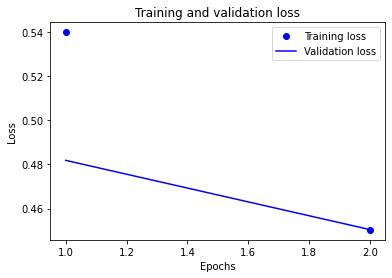

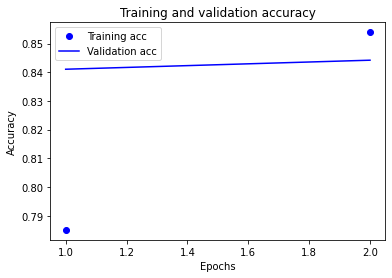

In [80]:
history_dict = lstm_model.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 그림을 초기화
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### cnn

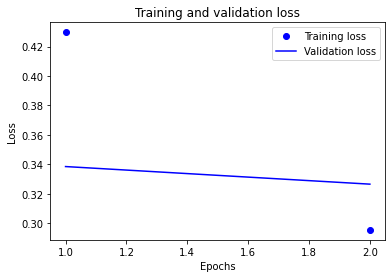

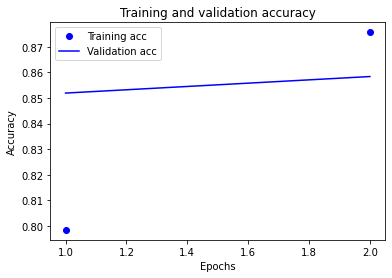

In [79]:
history_dict = cnn_model.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 그림을 초기화
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### gmax

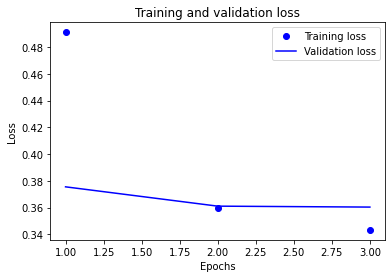

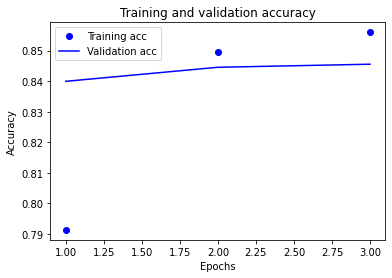

In [81]:
history_dict = gmax_model.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 그림을 초기화
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 과적합은 안난듯 보인다. 이제 학습된 임베딩 레이어를 보도록하자
### 7) 학습된 Embedding 레이어 분석

In [84]:
embedding_lstm = lstm.layers[0]
weights_lstm = embedding_lstm.get_weights()[0]

embedding_cnn = cnn.layers[0]
weights_cnn = embedding_cnn.get_weights()[0]

embedding_gmax = gmax.layers[0]
weights_simple = embedding_gmax.get_weights()[0]

word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_simple = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_gmax.txt'
f = open(word2vec_file_path_simple, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = simple.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)

word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)

word_vectors_gmax = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_simple, binary=False)

### 이제 한국어 word2vecd을 적용시키자.

In [87]:
import pprint

path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_vec = Word2Vec.load(path)

print(ko_vec.wv["배우"]) # ko_vec["배우"]방식은 deprecated라고 한다.
pprint.pprint(ko_vec.wv.most_similar("배우")) #마찬가지로 ko_vec.most_similar() 방식도 deprecated. 지양하자.

ko_vec = ko_vec.wv # ko_vec.wv대신 ko_vec을 사용하면 아래에서도 deprecated 경고 발생

[ 0.16752283 -1.4403394   2.8093226  -2.2942572   0.13433917 -1.0179986
 -1.6604831   1.4500121   0.26260966 -0.9908764  -0.86152965  0.2907808
 -0.71542895  0.11167914 -0.03550755  1.0984114  -1.266807   -1.73354
  1.6347289  -0.6296538  -0.4523188  -0.5940362  -0.07651725 -1.8494816
 -1.3535714  -2.3276203   1.3144854   1.9779409  -0.4396118   1.5602161
  1.4577893   1.1083381   0.65025765  0.51086545  0.1116109   0.46636197
 -0.50944877 -0.5409319  -1.0953526  -2.4960513  -0.28755617 -0.7519181
  0.6840282  -0.69424474 -0.24744606  0.03568178  3.426236   -2.2075064
 -0.38595662 -0.11880949  1.7459064  -1.8460087   1.8704582  -0.8907359
  0.258816    0.46029854  2.7752008   0.83754796 -1.1874206   0.22281261
  2.1227393   0.64509875 -2.9229567   1.8654289  -0.32230487 -1.6857306
  0.39045802  0.935903    0.02172696  0.0644962   0.9145913  -0.95547587
 -1.2014496  -0.16720626  0.86859787  0.07173832  0.60098696  0.5265061
  1.744407   -0.01287265 -1.8676045  -0.30340263  1.6570233  -1

In [88]:
vocab_size_ko_vec = 10000
word_vector_dim_ko_vec = 200

embedding_matrix = np.random.rand(vocab_size_ko_vec, word_vector_dim_ko_vec)

for i in range(4,vocab_size_ko_vec):
    if index_to_word[i] in ko_vec:
        embedding_matrix[i] = ko_vec[index_to_word[i]]

In [139]:
vocab_size = 10000
word_vector_dim = 200 #https://github.com/Kyubyong/wordvectors 참고. 한국어 word2vec는 벡터 사이즈가 200이다.

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
lstm.add(keras.layers.LSTM(128))
lstm.add(keras.layers.Dense(128, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))
lstm.summary()

cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
cnn.add(keras.layers.Conv1D(512, 6, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(6))
cnn.add(keras.layers.Conv1D(512, 6, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(256, activation='relu'))
cnn.add(keras.layers.Dense(128, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))
cnn.summary()

gmax = keras.Sequential()
gmax.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
gmax.add(keras.layers.GlobalAveragePooling1D())
gmax.add(keras.layers.Dense(256, activation='relu'))
gmax.add(keras.layers.Dense(128, activation='relu'))
gmax.add(keras.layers.Dense(1, activation='sigmoid'))
gmax.summary()

Model: "sequential_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_161 (Embedding)    (None, 41, 200)           2000000   
_________________________________________________________________
lstm_55 (LSTM)               (None, 128)               168448    
_________________________________________________________________
dense_353 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_354 (Dense)            (None, 1)                 129       
Total params: 2,185,089
Trainable params: 2,185,089
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_162 (Embedding)    (None, 41, 200)           2000000   
__________________

### 모델 학습

In [140]:
lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

lstm_model = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=2,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

cnn_model = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=3,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

gmax.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

gmax_model = gmax.fit(partial_X_train,
                    partial_y_train,
                    epochs=4,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/2
247/247 [==============================] - 6s 15ms/step - loss: 0.4505 - accuracy: 0.7828 - val_loss: 0.3616 - val_accuracy: 0.8401
Epoch 2/2
247/247 [==============================] - 3s 13ms/step - loss: 0.3245 - accuracy: 0.8599 - val_loss: 0.3237 - val_accuracy: 0.8605
Epoch 1/3
247/247 [==============================] - 9s 35ms/step - loss: 0.5110 - accuracy: 0.7449 - val_loss: 0.3902 - val_accuracy: 0.8228
Epoch 2/3
247/247 [==============================] - 8s 34ms/step - loss: 0.3353 - accuracy: 0.8544 - val_loss: 0.3562 - val_accuracy: 0.8448
Epoch 3/3
247/247 [==============================] - 8s 34ms/step - loss: 0.2608 - accuracy: 0.8919 - val_loss: 0.3553 - val_accuracy: 0.8481
Epoch 1/4
247/247 [==============================] - 2s 5ms/step - loss: 0.5204 - accuracy: 0.7339 - val_loss: 0.4167 - val_accuracy: 0.8130
Epoch 2/4
247/247 [==============================] - 1s 4ms/step - loss: 0.3920 - accuracy: 0.8239 - val_loss: 0.3668 - val_accuracy: 0.8378
Epoch 3/

### 역시 nlp에 관한 모델은 rnn쪽이 성능이 좋은것같다. lstm말고는 정확도를 85프로 이상 끌어올리기가 힘들었다.
### 이것으로 explolation09를 마친다.